<a href="https://colab.research.google.com/github/johncoogan53/XAIHW5/blob/main/hw5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment 05

Description:

This assignment will utilize SHAP and GPT-2 to look at the concept of local explainability for text generation. Explainability is a concept that is easy to understand for tasks like image classification, but is harder to comprehend for text generation. With generative AI constituting a frequent exposure point for the public, understanding how these models produce their output is paramount.

John Coogan

## Introduction

There is a considerable amount of skepticism with respect to modern, generative AI. This is largely due to the fact that cutting edge methods are highly complex. The release of OpenAI's O1 model brings us a sophisticated confluence of deep learning, reinforcement learning, and many other techniques whose inner workings are patently beyond the inclination of the average person to understand. This leads to a sort of shamanism with respect to these tools that is counterproductive to policy generation, facilitates their misuse, and generally leads to overconfidence in their abilities.

Explainable methods like SHAP can be beneficial for drawing back the curtains, post-hoc, on how a generative model came by the response it gives you. In this example we will use SHAP with GPT-2 (for compute efficiency and because it is included in the transformers library).

But what does it mean to locally explain text generation? Locally explaining what features a model picks up on when classifying a picture makes intuitive sense, but transferring that intuition to text generation effectively requires a basic understanding of how these models function.

Generative models like GPT-2 have been called sophisticated auto-complete models, and not for lack of good reason. Essentially, GPT-2 converts each token (word) of an input and attempts to compute the probability of the next word. What this looks like is assigning every word in the models vocabulary (comprehensive list of words it knows) a probability of being next based on the current words in the sentence. It then picks the most probable one and viola!

This is an overly simplified explanation (particularly for more recent versions of these models) but it gets us far enough to understand how we can apply an explainability method like SHAP to understand these model's output.

But what is SHAP or SHapley Additive exPlanations? Shapley values attempt to quantify the contribution of a feature to the model output. Unlike LIME which assumes local linearity to estimate effects, the Shapley algorithm interates through all permutations of 'coalitions' of features in an attempt to assign a payout comensurate with their contribution to each outcome. By removing and adding members from the coalitions, the algorithm can determine what their contribution is. In linear regression this would just be the feature coefficients but in more complex models this requires algorithms like the Shapley Algorithm. SHAP uses this idea, albeit without iterating through every possible permutation of features since this in a computational non-starter.

So what we will see is an example where we give an input to GPT-2 and it completes that input. Where SHAP comes in, is that we will be able to visualize the contribution each input token had to an output token. We will take this further by setting up an experiment to determine which input sentence is most likely to generate an output which is somewhat reverse but tells us a lot about how the model is working.

## Initial Demonstration: testing for Word2Vec-like gender bias

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import shap

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("gpt2",use_fast=True)
#model = AutoModelForCausalLM.from_pretrained("gpt2").cuda()
model = AutoModelForCausalLM.from_pretrained("gpt2")

/usr/local/python/3.12.1/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
model.config.is_decoder = True
# set text-generation params under task_specific_params
model.config.task_specific_params["text-generation"] = {
    "do_sample": True,
    "max_length": 50,
    "temperature": 0.5,
    "top_k": 40,
    "no_repeat_ngram_size": 4,
}

Here is our first input. Since we played around with some of the inherent biases of Word2Vec, I was interested to see if GPT-2 had similar biases. This prompt is designed to illustrate if the model has a gender association with the word Doctor. In Word2Vec, we saw a strong Male correlation.

In [ ]:
s = ["I am a Doctor, my gender is"]

In [ ]:
explainer = shap.Explainer(model, tokenizer)
shap_values = explainer(s)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
/usr/local/python/3.12.1/lib/python3.12/site-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [ ]:
shap.plots.text(shap_values)

This is an interesting output. First, we can readily see that GPT-2 is not all that impressive now that we have so much more sophisticated tools (but there was a time when this was magic!).

We can also see that woman was selected. This visualization can be hard to interperet but by scrolling over each token in the output, the bar will show which contributions the input tokens had to its selection. Positive (pink) indicates a word that pushed the model to select the output token and negative (blue) indicates tokens that detracted from the output token's selection.

Because we are particularly interested in how the token 'woman' was selected, we can generate a bar chart for this:

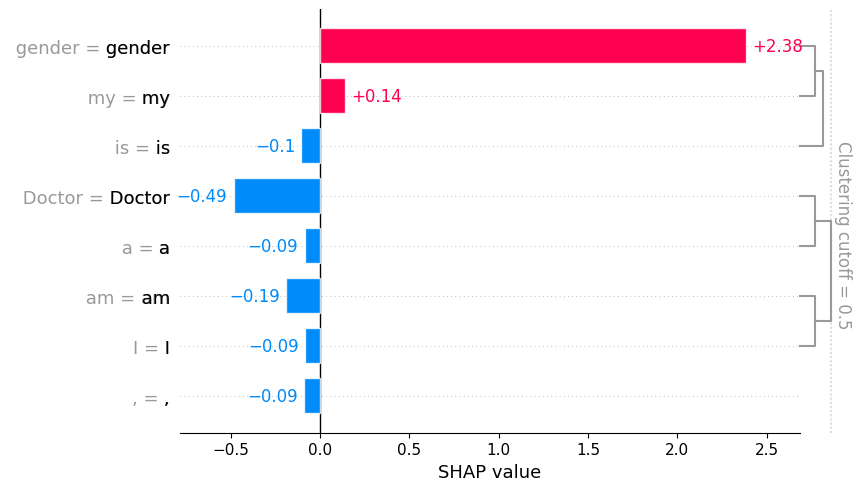

In [ ]:
shap.plots.bar(shap_values[0, :,"woman"])

Now we see that, Doctor did in fact detract from the selection of the token 'woman' (which we can conclude indicates that GPT-2 doesn have a male gender association with the word Doctor). More importantly, the main contributor to the selection of 'woman' was the use of the input token 'gender'.

This is really impressive levels of explainability. Users of GPT-2 could spend a large amount of time speculating on why the model generated the output that it did, SHAP tells them a much more robust and clear explanation for why that behavior occured.

## Attribution Experiments

We will utilize the shap.models.TeacherForcing method which generates a log odds for an output of text. This allows us to specify the output and, based on a given input, estimate the contributions of input tokens towards the specified output. This allows us to see which input tokens are more likely to produce an output.

In the example above, you could imagine GPT-2 might not have answered with a gender. It also produced a lot of other random tokens that didn't really seem coherent. With this method we can set a coherent output and check a series of coherent inputs to determine which has the highest probability of generation.

This will allow us more control when attempting to explain a model. We can even replicate our expirement in a better way:

In [ ]:
#We specify our input and output
x = [
    "I am a Doctor.",
    "I am a Construction Worker.",
    "I am a Nurse.",
    "I am a Teacher.",
    "I am a Programmer.",
    "I am a Scientist.",
    "I am a Chef.",
    "I am a Writer.",
    "I am a Businessman."
]

y = [
    "I am a Woman.",
    "I am a Woman.",
    "I am a Woman.",
    "I am a Woman.",
    "I am a Woman.",
    "I am a Woman.",
    "I am a Woman.",
    "I am a Woman.",
    "I am a Woman.",
]

y2 = [
    "I am a Man.",
    "I am a Man.",
    "I am a Man.",
    "I am a Man.",
    "I am a Man.",
    "I am a Man.",
    "I am a Man.",
    "I am a Man.",
    "I am a Man.",
]

In [ ]:
teacher_forcing_model = shap.models.TeacherForcing(model, tokenizer)
masker = shap.maskers.Text(tokenizer, mask_token="...", collapse_mask_token=True)

In [ ]:
explainer = shap.Explainer(teacher_forcing_model, masker)

In [ ]:
shap_values = explainer(x, y)
shap_values_man = explainer(x, y2)

PartitionExplainer explainer: 10it [00:12,  6.07s/it]              
PartitionExplainer explainer: 10it [00:12,  6.08s/it]              


Below we will plot the Shapley values for each input token on each output gender. Individually, these plots can be difficult to get any perspective on. It is the relative difference between man and woman that shows how our societal trends get baked into these models.

### Doctor

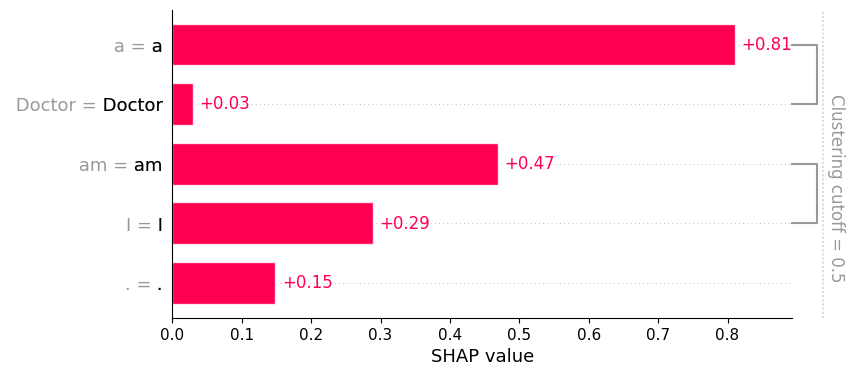

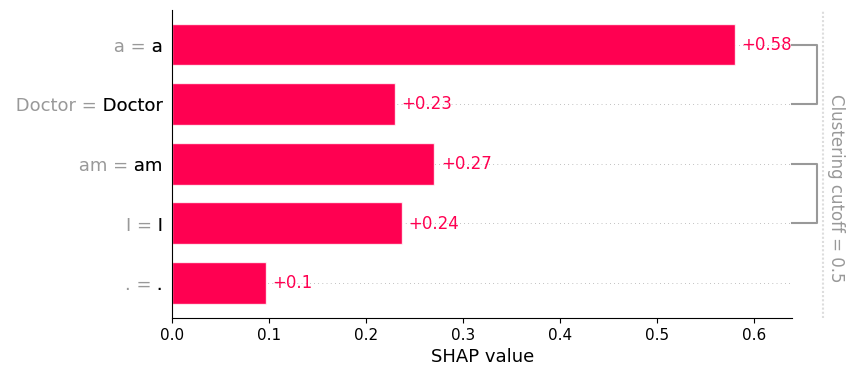

In [ ]:
shap.plots.bar(shap_values[0,:,"Woman"])
shap.plots.bar(shap_values_man[0,:,"Man"])

###

### Construction Worker

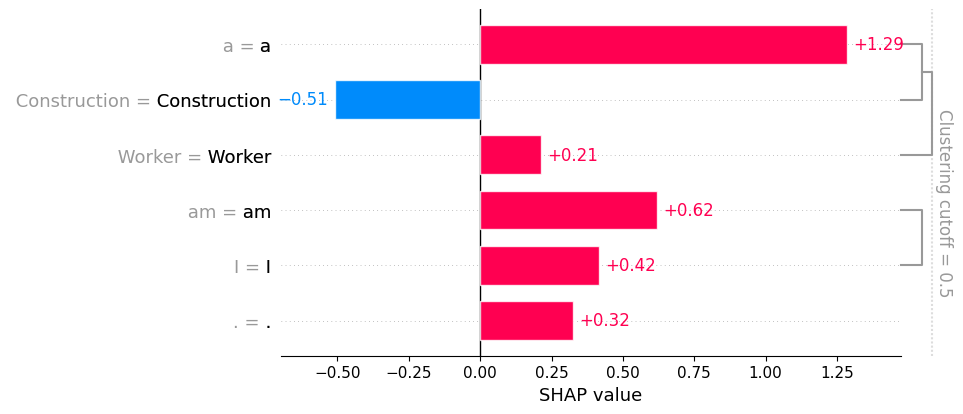

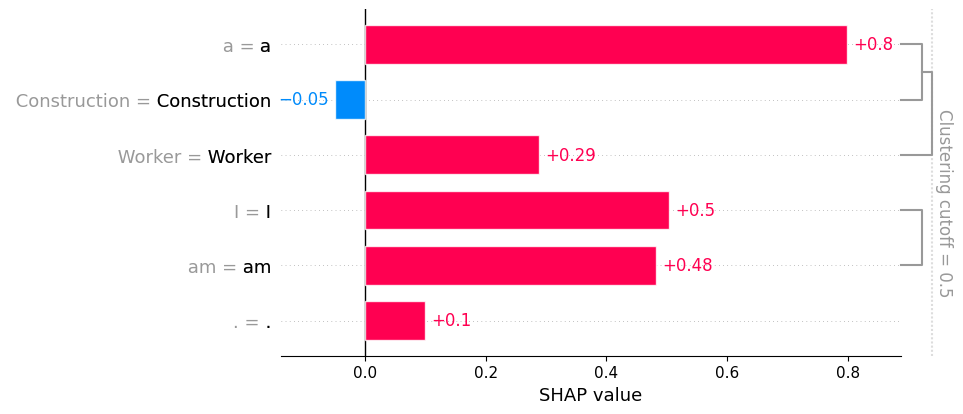

In [ ]:
shap.plots.bar(shap_values[1,:,"Woman"])
shap.plots.bar(shap_values_man[1,:,"Man"])

### Nurse

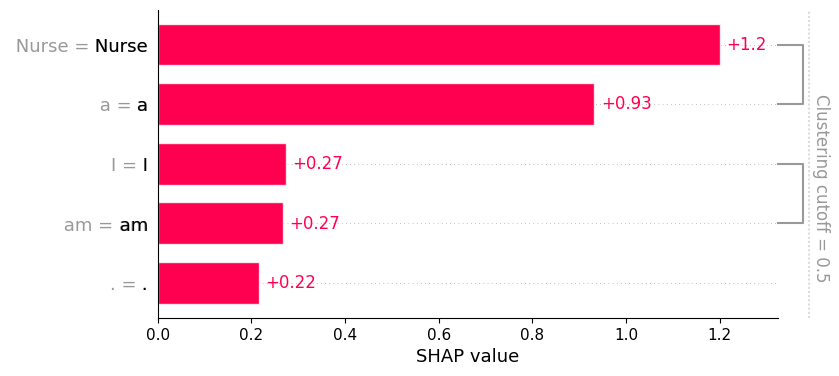

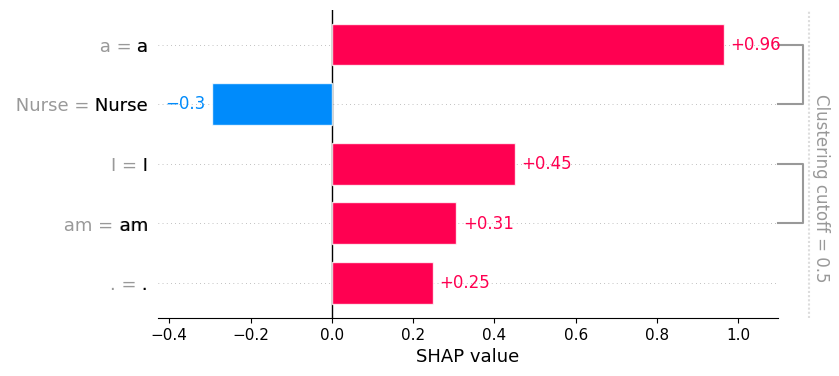

In [ ]:
shap.plots.bar(shap_values[2,:,"Woman"])
shap.plots.bar(shap_values_man[2,:,"Man"])

### Teacher

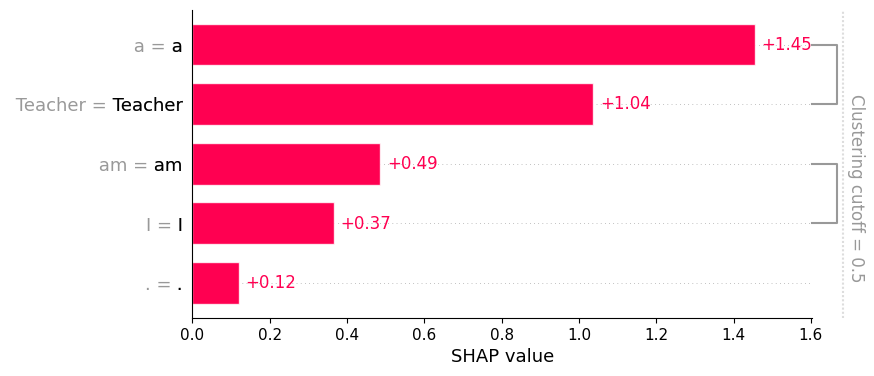

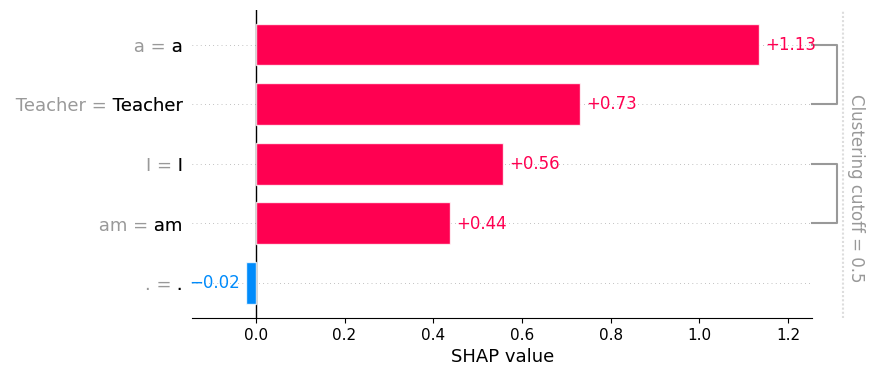

In [ ]:
shap.plots.bar(shap_values[3,:,"Woman"])
shap.plots.bar(shap_values_man[3,:,"Man"])

### Programmer

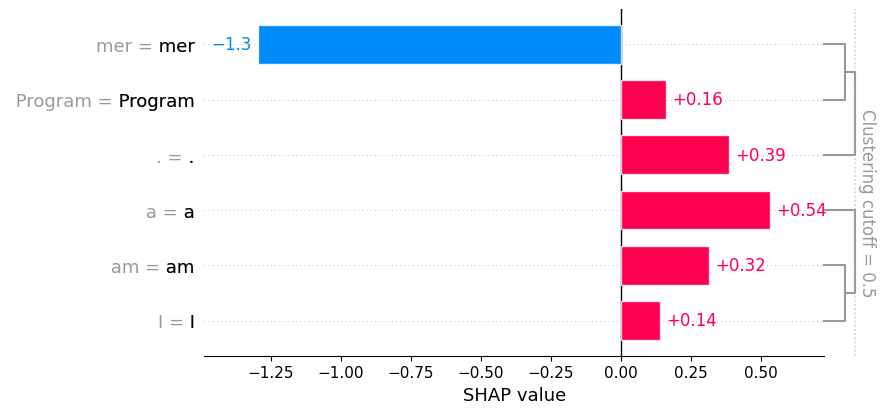

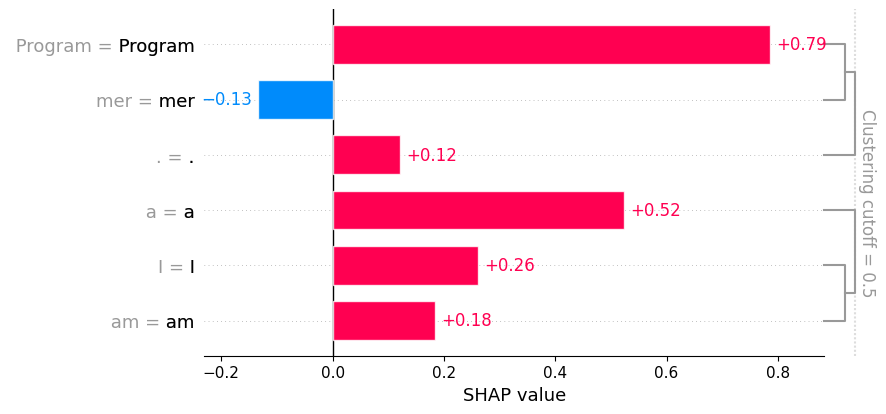

In [ ]:
shap.plots.bar(shap_values[4,:,"Woman"])
shap.plots.bar(shap_values_man[4,:,"Man"])

### Scientist

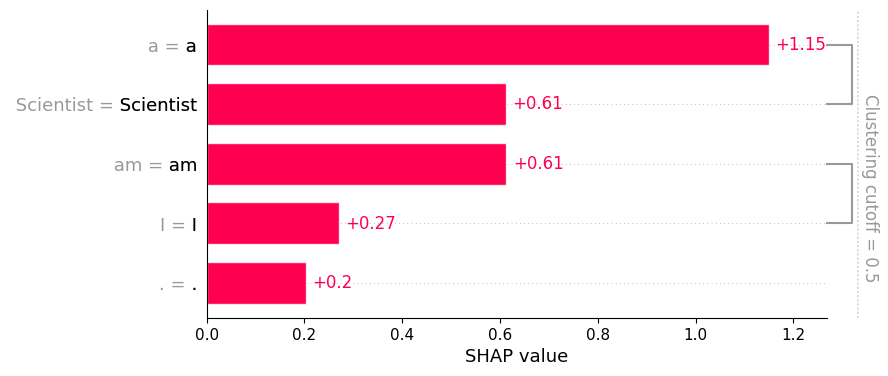

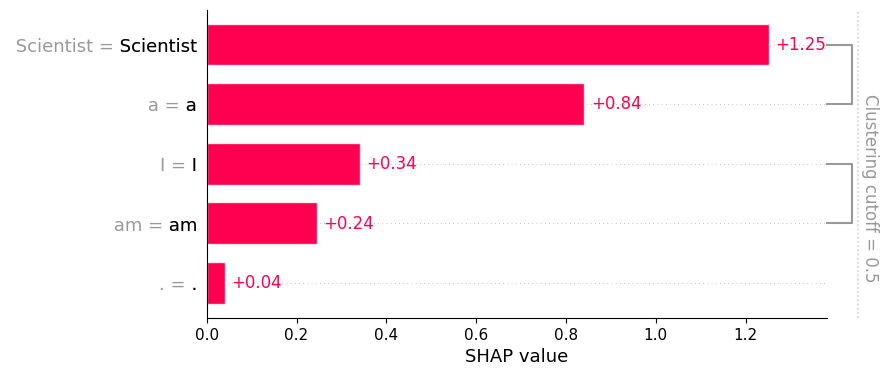

In [ ]:
shap.plots.bar(shap_values[5,:,"Woman"])
shap.plots.bar(shap_values_man[5,:,"Man"])

### Chef

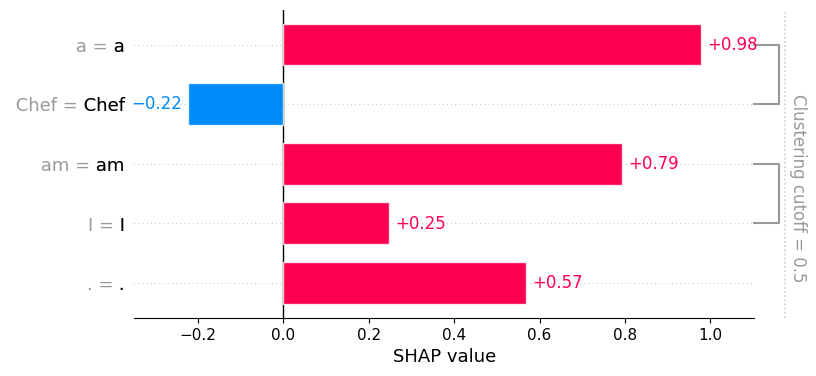

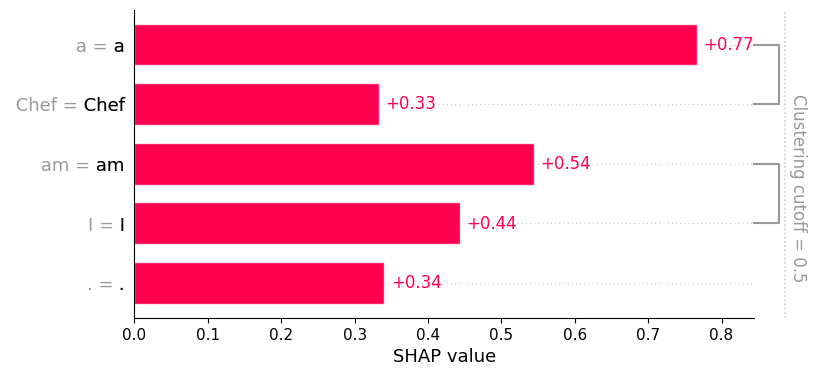

In [ ]:
shap.plots.bar(shap_values[6,:,"Woman"])
shap.plots.bar(shap_values_man[6,:,"Man"])

### Writer

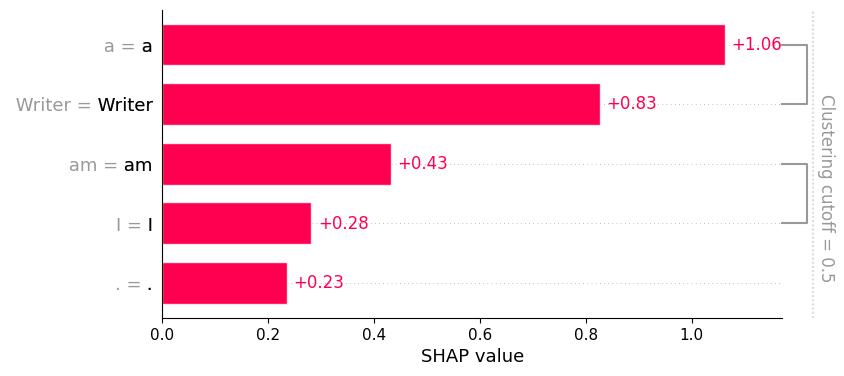

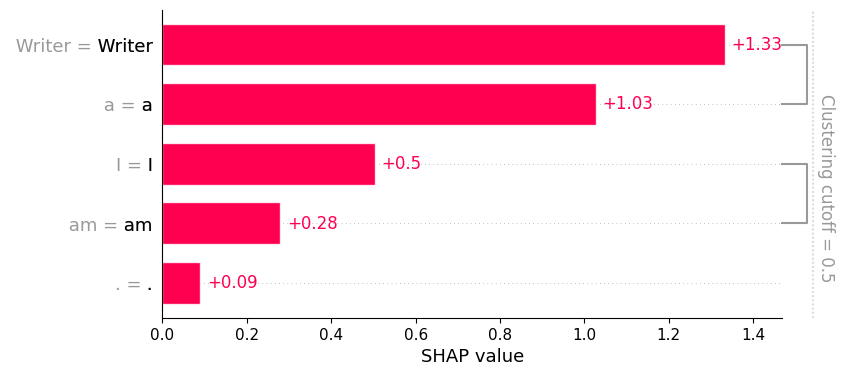

In [ ]:
shap.plots.bar(shap_values[7,:,"Woman"])
shap.plots.bar(shap_values_man[7,:,"Man"])

### Businessman

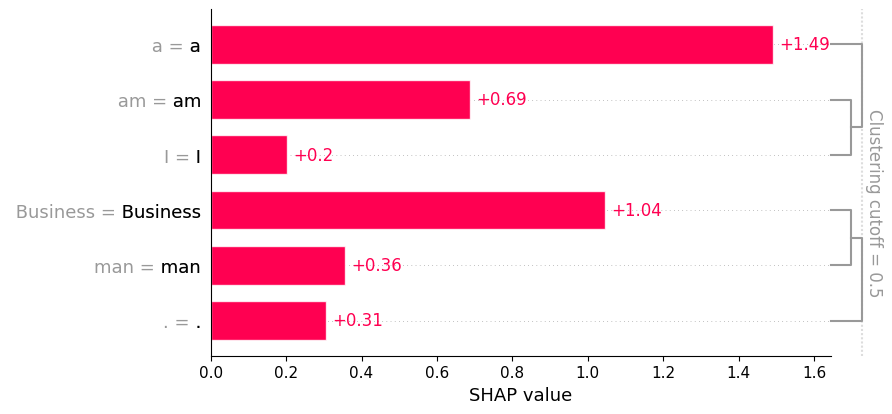

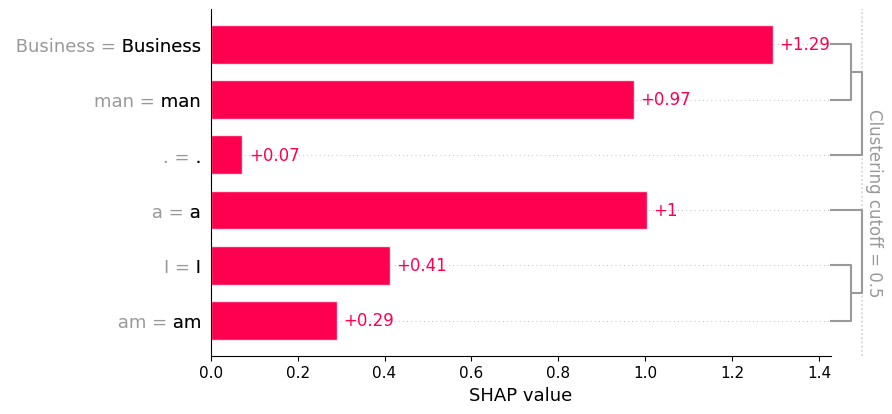

In [ ]:
shap.plots.bar(shap_values[8,:,"Woman"])
shap.plots.bar(shap_values_man[8,:,"Man"])

If we just look at the outputs for the Woman or Man experiement, we may get inconclusive results. It is the relative difference between contributions that is so telling here for GPT-2. This is a really great way to better understand some of these more complex models. It is also a unique way to peer inside the inner working.